In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

🎬 NETFLIX RECOMMENDATION ENGINE
No dataset, Creating sample Netflix data...
Sample dataset created successfully!
Movies dataset shape: (500, 3)
Ratings dataset shape: (29715, 4)

NETFLIX RECOMMENDATION ENGINE - COMPLETE ANALYSIS REPORT
EXPLORATORY DATA ANALYSIS

Merged dataset shape: (29715, 6)

First few rows:
   user_id  movie_id  rating   timestamp      title       genres
0        1       302       4  1286042407  Movie_302  Documentary
1        1       161       4  1545222157  Movie_161       Sci-Fi
2        1       480       5  1533012092  Movie_480    Animation
3        1       378       3  1011683982  Movie_378       Comedy
4        1       128       4  1452528272  Movie_128      Romance

Number of unique users: 1000
Number of unique movies: 500
Number of unique genres: 10
Total ratings: 29715

Rating distribution:
rating
1     1537
2     3003
3     5905
4    10264
5     9006
Name: count, dtype: int64
GENRE ANALYSIS

Most Popular Genres (by number of ratings):
genres
Action      

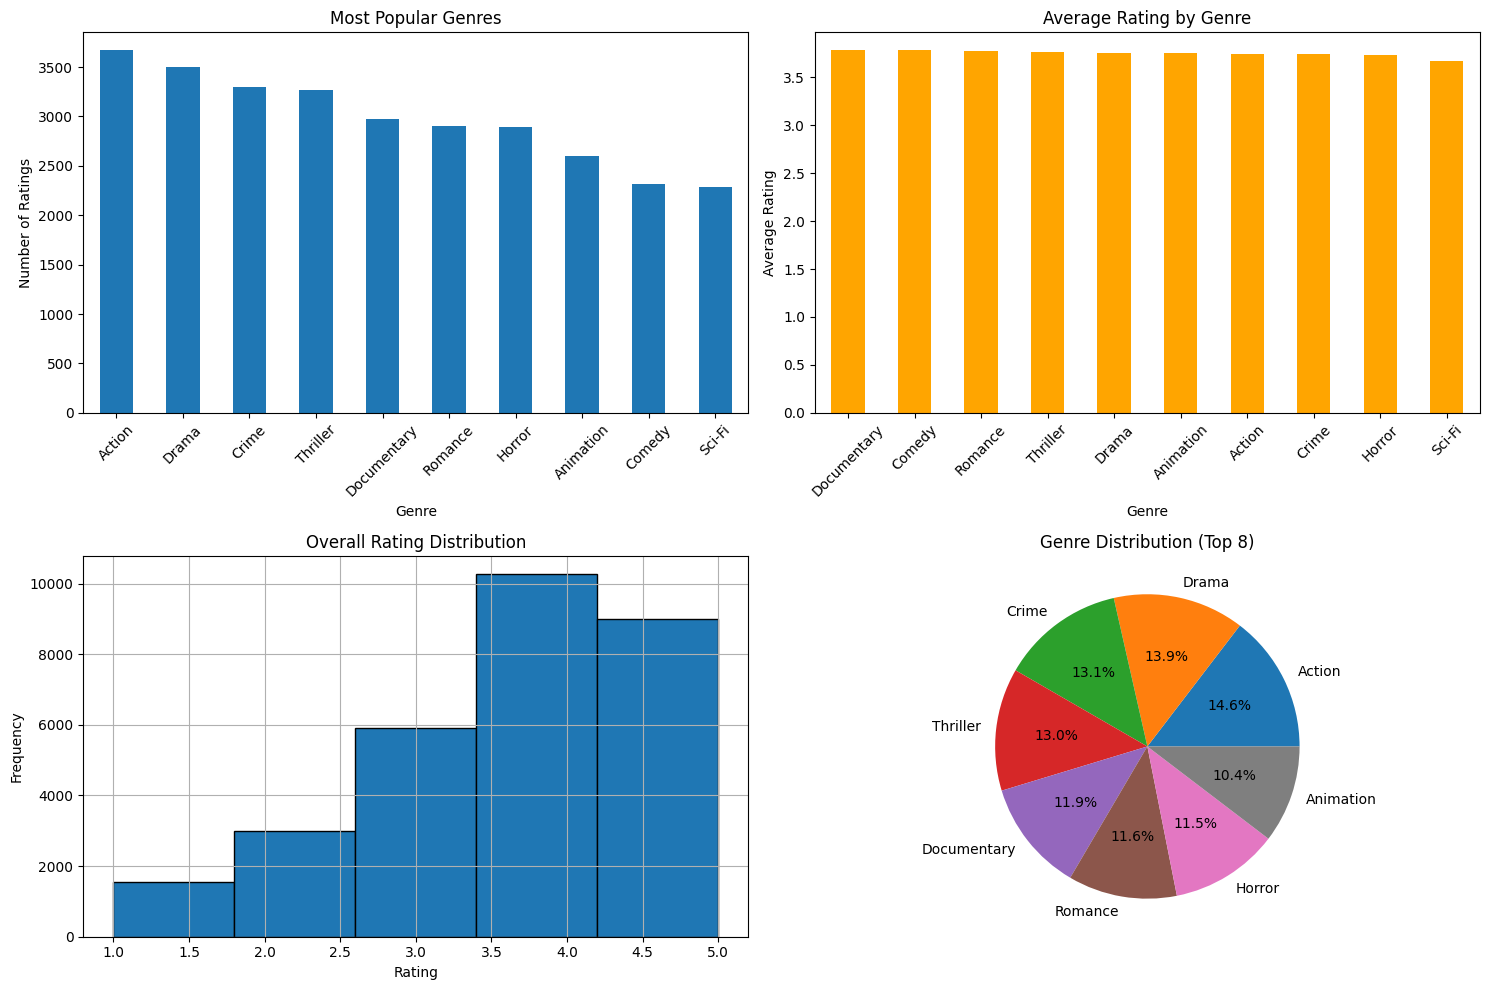

 CREATING USER-MOVIE MATRIX 
User-Movie Matrix shape: (1000, 500)
Matrix sparsity: 94.06%

SAMPLE RECOMMENDATIONS

==================== USER 1 ====================
 HYBRID RECOMMENDATIONS FOR USER 1 
COLLABORATIVE FILTERING FOR USER 1 
Top 5 similar users to User 1:
1. User 440: Similarity = 0.235
2. User 181: Similarity = 0.214
3. User 836: Similarity = 0.207
4. User 723: Similarity = 0.206
5. User 410: Similarity = 0.206

Top 5 Collaborative Filtering Recommendations for User 1:
1. Movie_69 (Thriller) - Predicted Rating: 5.00
2. Movie_483 (Romance) - Predicted Rating: 5.00
3. Movie_34 (Drama) - Predicted Rating: 5.00
4. Movie_25 (Animation) - Predicted Rating: 5.00
5. Movie_57 (Comedy) - Predicted Rating: 5.00
 CONTENT-BASED FILTERING FOR USER 1 
User 1 has rated 50 movies

User 1's Genre Preferences:
             mean  count
genres                  
Sci-Fi       4.50      4
Drama        4.38      8
Romance      4.17      6
Crime        4.00      7
Horror       4.00      6
Comedy    

In [29]:


class NetflixRecommendationEngine:
    def __init__(self):
        self.movies_df = None
        self.ratings_df = None
        self.merged_df = None
        self.user_movie_matrix = None
        self.movie_similarity_matrix = None

    def load_data(self, movies_path=None, ratings_path=None):
        try:
            if movies_path and ratings_path:
                self.movies_df = pd.read_csv(movies_path)
                self.ratings_df = pd.read_csv(ratings_path)
            else:
                # Create sample data if no files provided
                print("No dataset, Creating sample Netflix data...")
                self.create_sample_data()

            print(f"Movies dataset shape: {self.movies_df.shape}")
            print(f"Ratings dataset shape: {self.ratings_df.shape}")

        except Exception as e:
            print(f"Error loading data: {e}")
            print("Creating sample data instead...")
            self.create_sample_data()

    def create_sample_data(self):
        np.random.seed(42)

        # Sample movies with genres
        movies_data = {
            'movie_id': range(1, 501),  # 500 movies
            'title': [f"Movie_{i}" for i in range(1, 501)],
            'genres': np.random.choice([
                'Action', 'Comedy', 'Drama', 'Horror', 'Romance',
                'Sci-Fi', 'Thriller', 'Documentary', 'Animation', 'Crime'
            ], 500)
        }

        self.movies_df = pd.DataFrame(movies_data)

        # Sample ratings
        ratings_data = []
        for user_id in range(1, 1001):  # 1000 users
            # Each user rates 10-50 movies randomly
            n_ratings = np.random.randint(10, 51)
            movie_ids = np.random.choice(range(1, 501),
                                         n_ratings, replace=False)

            for movie_id in movie_ids:
                rating = np.random.choice([1, 2, 3, 4, 5],
                                          p=[0.05, 0.1, 0.2, 0.35, 0.3])
                ratings_data.append({
                    'user_id': user_id,
                    'movie_id': movie_id,
                    'rating': rating,
                    'timestamp': np.random.randint(1000000000, 1600000000)
                })

        self.ratings_df = pd.DataFrame(ratings_data)
        print("Sample dataset created successfully!")

    def explore_data(self):
        print("EXPLORATORY DATA ANALYSIS")

        # Merge datasets
        self.merged_df = pd.merge(self.ratings_df,
                                  self.movies_df, on='movie_id', how='inner')

        print(f"\nMerged dataset shape: {self.merged_df.shape}")
        print("\nFirst few rows:")
        print(self.merged_df.head())

        # Basic statistics
        print(f"\nNumber of unique users: {self.merged_df['user_id'].nunique()}")
        print(f"Number of unique movies: {self.merged_df['movie_id'].nunique()}")
        print(f"Number of unique genres: {self.merged_df['genres'].nunique()}")
        print(f"Total ratings: {len(self.merged_df)}")

        # Rating distribution
        print("\nRating distribution:")
        print(self.merged_df['rating'].value_counts().sort_index())

        return self.merged_df

    def analyze_genres(self):
        """Analyze genre popularity and ratings - Objective 1 & 3"""
        print("GENRE ANALYSIS")

        # Most popular genres (by number of ratings)
        genre_popularity = self.merged_df['genres'].value_counts()
        print("\nMost Popular Genres (by number of ratings):")
        print(genre_popularity.head(10))

        # Average rating by genre
        genre_ratings = self.merged_df.groupby('genres')['rating'].agg(['mean', 'count', 'std']).round(2)
        genre_ratings = genre_ratings.sort_values('mean', ascending=False)

        print("\nGenre Ratings Analysis:")
        print(genre_ratings)

        # Best and worst rated genres
        best_genre = genre_ratings.index[0]
        worst_genre = genre_ratings.index[-1]

        print(f"\nBest rated genre: {best_genre} (Average: {genre_ratings.loc[best_genre, 'mean']})")
        print(f"Worst rated genre: {worst_genre} (Average: {genre_ratings.loc[worst_genre, 'mean']})")

        # Visualization
        plt.figure(figsize=(15, 10))

        # Genre popularity
        plt.subplot(2, 2, 1)
        genre_popularity.head(10).plot(kind='bar')
        plt.title('Most Popular Genres')
        plt.xlabel('Genre')
        plt.ylabel('Number of Ratings')
        plt.xticks(rotation=45)

        # Average rating by genre
        plt.subplot(2, 2, 2)
        genre_ratings['mean'].plot(kind='bar', color='orange')
        plt.title('Average Rating by Genre')
        plt.xlabel('Genre')
        plt.ylabel('Average Rating')
        plt.xticks(rotation=45)

        # Rating distribution
        plt.subplot(2, 2, 3)
        self.merged_df['rating'].hist(bins=5, edgecolor='black')
        plt.title('Overall Rating Distribution')
        plt.xlabel('Rating')
        plt.ylabel('Frequency')

        # Genre count
        plt.subplot(2, 2, 4)
        plt.pie(genre_popularity.head(8).values, labels=genre_popularity.head(8).index, autopct='%1.1f%%')
        plt.title('Genre Distribution (Top 8)')

        plt.tight_layout()
        plt.show()

        return genre_ratings

    def create_user_movie_matrix(self):
        """Create user-movie rating matrix"""
        print(" CREATING USER-MOVIE MATRIX ")

        # Create pivot table
        self.user_movie_matrix = self.merged_df.pivot_table(
            index='user_id',
            columns='movie_id',
            values='rating'
        ).fillna(0)

        print(f"User-Movie Matrix shape: {self.user_movie_matrix.shape}")
        print(f"Matrix sparsity: {(self.user_movie_matrix == 0).sum().sum() / (self.user_movie_matrix.shape[0] * self.user_movie_matrix.shape[1]) * 100:.2f}%")

        return self.user_movie_matrix

    def collaborative_filtering_recommendations(self, user_id, n_recommendations=5):
        """User-based collaborative filtering"""
        print(f"COLLABORATIVE FILTERING FOR USER {user_id} ")

        if self.user_movie_matrix is None:
            self.create_user_movie_matrix()

        # Get user ratings
        user_ratings = self.user_movie_matrix.loc[user_id]

        # Find similar users
        user_similarity = cosine_similarity([user_ratings], self.user_movie_matrix)[0]
        similar_users = pd.Series(user_similarity, index=self.user_movie_matrix.index).sort_values(ascending=False)

        # Get top similar users (excluding the user themselves)
        top_similar_users = similar_users.drop(user_id).head(10)

        print(f"Top 5 similar users to User {user_id}:")
        for idx, (similar_user, similarity) in enumerate(top_similar_users.head(5).items()):
            print(f"{idx+1}. User {similar_user}: Similarity = {similarity:.3f}")

        # Get movies rated by similar users but not by target user
        unrated_movies = user_ratings[user_ratings == 0].index

        # Calculate predicted ratings
        movie_scores = {}
        for movie_id in unrated_movies:
            weighted_rating = 0
            similarity_sum = 0

            for similar_user in top_similar_users.index:
                if self.user_movie_matrix.loc[similar_user, movie_id] > 0:
                    weighted_rating += (top_similar_users[similar_user] *
                                      self.user_movie_matrix.loc[similar_user, movie_id])
                    similarity_sum += top_similar_users[similar_user]

            if similarity_sum > 0:
                movie_scores[movie_id] = weighted_rating / similarity_sum

        # Get top recommendations
        recommendations = pd.Series(movie_scores).sort_values(ascending=False).head(n_recommendations)

        print(f"\nTop {n_recommendations} Collaborative Filtering Recommendations for User {user_id}:")
        for idx, (movie_id, score) in enumerate(recommendations.items()):
            movie_title = self.movies_df[self.movies_df['movie_id'] == movie_id]['title'].values[0]
            movie_genre = self.movies_df[self.movies_df['movie_id'] == movie_id]['genres'].values[0]
            print(f"{idx+1}. {movie_title} ({movie_genre}) - Predicted Rating: {score:.2f}")

        return recommendations

    def content_based_recommendations(self, user_id, n_recommendations=5):
        """Content-based filtering using genres"""
        print(f" CONTENT-BASED FILTERING FOR USER {user_id} ")

        # Get user's rating history
        user_history = self.merged_df[self.merged_df['user_id'] == user_id]

        if len(user_history) == 0:
            print(f"No rating history found for User {user_id}")
            return None

        print(f"User {user_id} has rated {len(user_history)} movies")

        # Analyze user's genre preferences
        genre_preferences = user_history.groupby('genres')['rating'].agg(['mean', 'count']).round(2)
        genre_preferences = genre_preferences[genre_preferences['count'] >= 1].sort_values('mean', ascending=False)

        print(f"\nUser {user_id}'s Genre Preferences:")
        print(genre_preferences)

        # Get movies not rated by user
        rated_movies = user_history['movie_id'].unique()
        unrated_movies = self.movies_df[~self.movies_df['movie_id'].isin(rated_movies)]

        # Score movies based on user's genre preferences
        movie_scores = []
        for _, movie in unrated_movies.iterrows():
            genre = movie['genres']
            if genre in genre_preferences.index:
                # Score based on user's average rating for this genre
                score = genre_preferences.loc[genre, 'mean']
                movie_scores.append({
                    'movie_id': movie['movie_id'],
                    'title': movie['title'],
                    'genre': genre,
                    'score': score
                })

        # Sort and get top recommendations
        movie_scores_df = pd.DataFrame(movie_scores).sort_values('score', ascending=False)
        recommendations = movie_scores_df.head(n_recommendations)

        print(f"\nTop {n_recommendations} Content-Based Recommendations for User {user_id}:")
        for idx, row in recommendations.iterrows():
            print(f"{idx+1}. {row['title']} ({row['genre']}) - Expected Rating: {row['score']:.2f}")

        return recommendations

    def genre_specific_recommendations(self, user_id, genre, n_recommendations=3):
        """Find best suited movies for user in specific genre - Objective 2"""
        print(f" {genre.upper()} RECOMMENDATIONS FOR USER {user_id} ")

        # Get user's rating history
        user_history = self.merged_df[self.merged_df['user_id'] == user_id]

        if len(user_history) == 0:
            print(f"No rating history found for User {user_id}")
            return None

        # Get movies in the specified genre that user hasn't rated
        genre_movies = self.movies_df[self.movies_df['genres'] == genre]
        rated_movies = user_history['movie_id'].unique()
        unrated_genre_movies = genre_movies[~genre_movies['movie_id'].isin(rated_movies)]

        if len(unrated_genre_movies) == 0:
            print(f"User {user_id} has already rated all {genre} movies")
            return None

        # Get average ratings for each movie in this genre
        genre_movie_ratings = self.merged_df[self.merged_df['genres'] == genre].groupby(['movie_id', 'title'])['rating'].agg(['mean', 'count']).round(2)
        genre_movie_ratings = genre_movie_ratings[genre_movie_ratings['count'] >= 3]  # Movies with at least 3 ratings
        genre_movie_ratings = genre_movie_ratings.sort_values('mean', ascending=False)

        # Filter to only unrated movies
        recommendations = []
        for (movie_id, title), row in genre_movie_ratings.iterrows():
            if movie_id in unrated_genre_movies['movie_id'].values:
                recommendations.append({
                    'movie_id': movie_id,
                    'title': title,
                    'avg_rating': row['mean'],
                    'num_ratings': row['count']
                })

                if len(recommendations) >= n_recommendations:
                    break

        print(f"\nTop {len(recommendations)} {genre} movies for User {user_id}:")
        for idx, movie in enumerate(recommendations):
            print(f"{idx+1}. {movie['title']} - Avg Rating: {movie['avg_rating']:.2f} ({movie['num_ratings']} ratings)")

        return recommendations

    def hybrid_recommendations(self, user_id, n_recommendations=10):
        """Combine collaborative and content-based filtering"""
        print(f" HYBRID RECOMMENDATIONS FOR USER {user_id} ")

        # Get collaborative filtering recommendations
        try:
            cf_recs = self.collaborative_filtering_recommendations(user_id, n_recommendations)
            cf_movies = set(cf_recs.index) if cf_recs is not None else set()
        except:
            cf_movies = set()
            print("Collaborative filtering failed, using content-based only")

        # Get content-based recommendations
        try:
            cb_recs = self.content_based_recommendations(user_id, n_recommendations)
            cb_movies = set(cb_recs['movie_id'].values) if cb_recs is not None else set()
        except:
            cb_movies = set()
            print("Content-based filtering failed, using collaborative only")

        # Combine recommendations
        all_recommended_movies = cf_movies.union(cb_movies)

        if len(all_recommended_movies) == 0:
            print("No recommendations could be generated")
            return None

        # Get movie details for final recommendations
        final_recommendations = []
        for movie_id in list(all_recommended_movies)[:n_recommendations]:
            movie_info = self.movies_df[self.movies_df['movie_id'] == movie_id].iloc[0]
            avg_rating = self.merged_df[self.merged_df['movie_id'] == movie_id]['rating'].mean()

            final_recommendations.append({
                'movie_id': movie_id,
                'title': movie_info['title'],
                'genre': movie_info['genres'],
                'avg_rating': round(avg_rating, 2)
            })

        print(f"\nTop {len(final_recommendations)} Hybrid Recommendations for User {user_id}:")
        for idx, movie in enumerate(final_recommendations):
            print(f"{idx+1}. {movie['title']} ({movie['genre']}) - Avg Rating: {movie['avg_rating']}")

        return final_recommendations

    def evaluate_model(self):
        """Evaluate recommendation system performance"""
        print("MODEL EVALUATION ")

        # Split data into train/test
        train_data, test_data = train_test_split(self.merged_df, test_size=0.2, random_state=42)

        print(f"Training data: {len(train_data)} ratings")
        print(f"Test data: {len(test_data)} ratings")

        # Simple baseline: predict average rating for each movie
        movie_avg_ratings = train_data.groupby('movie_id')['rating'].mean()
        global_avg = train_data['rating'].mean()

        # Predict ratings for test set
        predictions = []
        actual_ratings = []

        for _, row in test_data.iterrows():
            movie_id = row['movie_id']
            actual_rating = row['rating']

            # Predict using movie average, or global average if movie not in training
            if movie_id in movie_avg_ratings.index:
                predicted_rating = movie_avg_ratings[movie_id]
            else:
                predicted_rating = global_avg

            predictions.append(predicted_rating)
            actual_ratings.append(actual_rating)

        # Calculate metrics
        mse = mean_squared_error(actual_ratings, predictions)
        mae = mean_absolute_error(actual_ratings, predictions)
        rmse = np.sqrt(mse)

        print(f"\nBaseline Model Performance:")
        print(f"RMSE: {rmse:.3f}")
        print(f"MAE: {mae:.3f}")
        print(f"MSE: {mse:.3f}")

        return {'rmse': rmse, 'mae': mae, 'mse': mse}

    def generate_report(self):
        """Generate comprehensive analysis report"""
        print("\n" + "="*60)
        print("NETFLIX RECOMMENDATION ENGINE - COMPLETE ANALYSIS REPORT")
        print("="*60)

        # Load and explore data
        self.explore_data()

        # Analyze genres (Objectives 1 & 3)
        genre_analysis = self.analyze_genres()

        # Create user-movie matrix
        self.create_user_movie_matrix()

        # Sample user recommendations
        sample_users = [1, 10, 50, 100]
        genres = self.merged_df['genres'].unique()[:5]  # Top 5 genres

        print(f"\n" + "="*50)
        print("SAMPLE RECOMMENDATIONS")
        print("="*50)

        for user_id in sample_users:
            if user_id in self.user_movie_matrix.index:
                print(f"\n{'='*20} USER {user_id} {'='*20}")

                # Hybrid recommendations
                self.hybrid_recommendations(user_id, 5)

                # Genre-specific recommendations (Objective 2)
                for genre in genres[:3]:  # Top 3 genres
                    self.genre_specific_recommendations(user_id, genre, 2)

        # Model evaluation
        evaluation_metrics = self.evaluate_model()

        print(f"\n" + "="*50)
        print("PROJECT OBJECTIVES SUMMARY")
        print("="*50)

        print("\n1. MOST POPULAR AND LIKED GENRES:")
        print("   ✓ Analysis completed - see genre analysis above")

        print("\n2. BEST SUITED MOVIES FOR USERS IN EVERY GENRE:")
        print("   ✓ Genre-specific recommendation system implemented")

        print("\n3. BEST AND WORST RATED GENRES:")
        print("   ✓ Genre rating analysis completed - see results above")

        print(f"\n" + "="*50)
        print("RECOMMENDATION ENGINE READY!")
        print("="*50)

        return evaluation_metrics

def main():
    """Main function to run the complete Netflix recommendation engine"""

    print("🎬 NETFLIX RECOMMENDATION ENGINE")
    print("="*50)

    # Initialize the recommendation engine
    engine = NetflixRecommendationEngine()

    # Option 1: Load your own data
    # engine.load_data('path_to_movies.csv', 'path_to_ratings.csv')

    # Option 2: Use sample data (default)
    engine.load_data()

    # Run complete analysis
    engine.generate_report()

    # Interactive recommendations
    print(f"\n" + "="*50)
    print("INTERACTIVE RECOMMENDATIONS")
    print("="*50)

    # You can now get recommendations for any user
    user_id = 1  # Change this to test different users
    print(f"\nGetting recommendations for User {user_id}...")

    # Get hybrid recommendations
    engine.hybrid_recommendations(user_id, 10)

    # Get genre-specific recommendations
    popular_genres = engine.merged_df['genres'].value_counts().head(3).index
    for genre in popular_genres:
        engine.genre_specific_recommendations(user_id, genre, 3)

if __name__ == "__main__":
    main()

# Additional utility functions for extended functionality

def save_recommendations_to_file(engine, user_id, filename):
    """Save user recommendations to a file"""
    recommendations = engine.hybrid_recommendations(user_id, 20)

    if recommendations:
        df = pd.DataFrame(recommendations)
        df.to_csv(filename, index=False)
        print(f"Recommendations saved to {filename}")

def batch_recommendations(engine, user_ids, output_dir="recommendations/"):
    """Generate recommendations for multiple users"""
    import os

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for user_id in user_ids:
        try:
            recommendations = engine.hybrid_recommendations(user_id, 10)
            if recommendations:
                filename = f"{output_dir}user_{user_id}_recommendations.csv"
                save_recommendations_to_file(engine, user_id, filename)
        except Exception as e:
            print(f"Error generating recommendations for User {user_id}: {e}")
